## Time-domain modelling and inversion

In [33]:
# We first import the needed modules
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt  # submodule of pg
from pygimli.physics import ert  # subsubmodule
import pybert as pb

Data: Electrodes: 81 data: 1260
Mesh: Nodes: 926 Cells: 1694 Boundaries: 2619


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2351de3a9a0>)

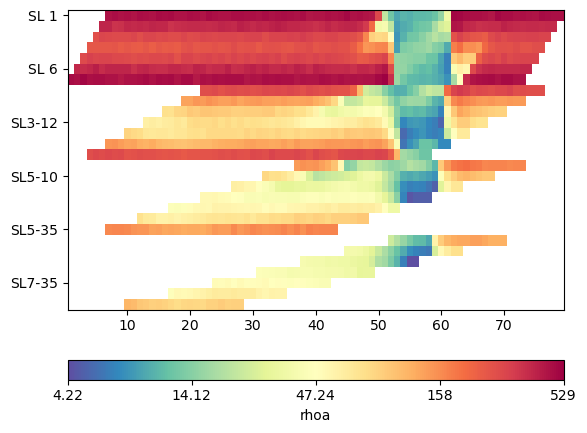

In [34]:
# We first load the synthetic model and data
data = ert.load("synth.dat")
print(data)
mesh = pg.load("synth.bms")
print(mesh)
pg.show(data)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2351de522e0>)

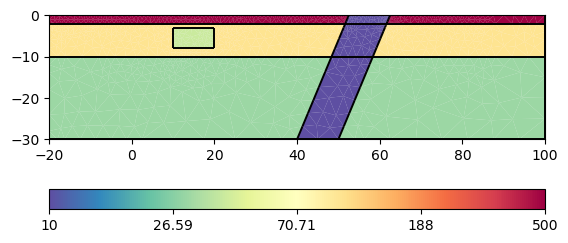

In [35]:
# Next, we are creating the IP forward response.
rhoVec = np.array([0, 500, 100, 30, 40, 10])[mesh.cellMarkers()]
pg.show(mesh, rhoVec, logScale=True, cMap="Spectral_r")

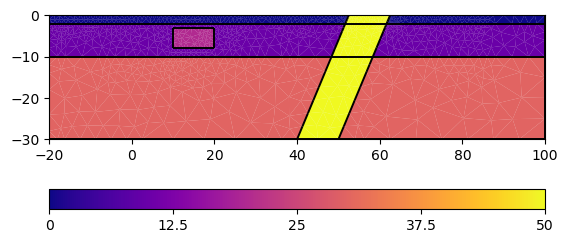

In [46]:
mVec = np.array([0, 0.0, 0.01, 0.03, 0.02, 0.05])[mesh.cellMarkers()]
ax, _ = pg.show(mesh, mVec*1000, cMap="plasma", cMin=0, cMax=50)

06/06/23 - 16:22:38 - pyGIMLi - INFO - Found 1 regions.
06/06/23 - 16:22:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/23 - 16:22:39 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/23 - 16:22:39 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3545 Cells: 6776 Boundaries: 5238
06/06/23 - 16:22:40 - pyGIMLi - INFO - Found 5 regions.
06/06/23 - 16:22:40 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)


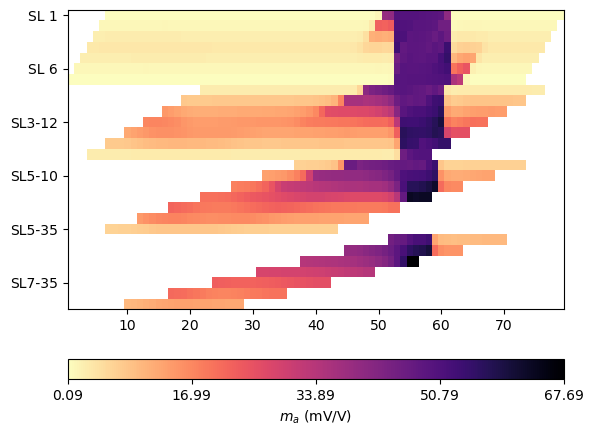

In [37]:
mesh0 = pg.Mesh(mesh)
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopDC = ert.ERTModelling()
fopDC.setMesh(mesh0)
fopDC.setData(data)
# data["rhoa"] = fopDC.response(rhoVec)
fopDC.createJacobian(rhoVec)
fopIP = pb.tdip.DCIPMModelling(fopDC, mesh, rhoVec)
data["ma"] = fopIP.response(mVec)
pg.show(data, data["ma"]*1000, logScale=False, label=r"$m_a$ (mV/V)", cMap="magma_r");


In [52]:
from pybert.tdip.modelling import IPSeigelModelling
f = IPSeigelModelling(fopDC, mesh0, rhoVec, data)
ma = f.response(mVec)
ert.show(data, ma)

ArgumentError: Python argument types in
    ModellingBase.__init__(IPSeigelModelling)
did not match C++ signature:
    __init__(_object*, GIMLI::Mesh mesh, GIMLI::DataContainer {lvalue} dataContainer)
    __init__(_object*, GIMLI::Mesh mesh, GIMLI::DataContainer {lvalue} dataContainer, bool verbose=False)
    __init__(_object*, GIMLI::Mesh mesh)
    __init__(_object*, GIMLI::Mesh mesh, bool verbose=False)
    __init__(_object*, GIMLI::DataContainer {lvalue} dataContainer)
    __init__(_object*, GIMLI::DataContainer {lvalue} dataContainer, bool verbose=False)
    __init__(_object*)
    __init__(_object*, bool verbose=False)

In [39]:
# We first run a DC inversion
mgr = ert.Manager(data)
mgr.invert(zWeight=0.2, paraDepth=22, verbose=True)

06/06/23 - 16:22:42 - pyGIMLi - INFO - Found 2 regions.
06/06/23 - 16:22:42 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/23 - 16:22:42 - pyGIMLi - INFO - Found 2 regions.
06/06/23 - 16:22:42 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/06/23 - 16:22:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/06/23 - 16:22:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/06/23 - 16:22:42 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3558 Cells: 6700 Boundaries: 5232
06/06/23 - 16:22:42 - pyGIMLi - INFO - Use median(data values)=125.6395316258325
06/06/23 - 16:22:42 - pyGIMLi - INFO - Created startmodel from forward operator: 1317 [125.6395316258325,...,125.6395316258325]
06/06/23 - 16:22:42 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002361FA73D60>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002361FA73EA0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002361FA77940>
min/max (data): 4.22/529
min/max (error): 3%/3.89%
min/max (start model): 126/126
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 74.44 (dPhi = 95.19%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 25.57 (dPhi = 65.05%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 18.32 (dPhi = 27.92%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 14.46 (dPhi = 20.67%) lam: 20.0
-------------------------------------

1317 [472.71763083991203,...,19.831946380466437]

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2362106d9d0>)

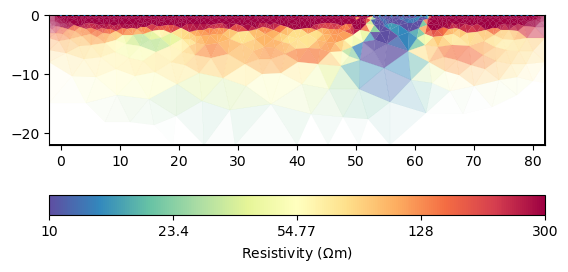

In [44]:
mgr.showResult(cMin=10, cMax=300)

We setup a new modelling class and do an inversion by hand.

In [48]:
mesh0 = mgr.paraDomain
mesh0.setCellMarkers(pg.Vector(mesh0.cellCount()))
fopIP = pb.tdip.DCIPMModelling(mgr.fop, mesh0, mgr.model, response=mgr.inv.response)
fopIP.createRefinedForwardMesh(True)
invIP = pg.Inversion(fop=fopIP, verbose=True)
modelIP = invIP.run(data["ma"], absoluteError=0.001, relativeError=0.03, 
                    startModel=0.1, lam=20, zWeight=0.2, verbose=True)


06/06/23 - 16:26:49 - pyGIMLi - INFO - Found 1 regions.
06/06/23 - 16:26:49 - pyGIMLi - INFO - Starting inversion.


fop: <pybert.tdip.modelling.DCIPMModelling object at 0x0000023621120130>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002351DB4DD00>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002351DB6A540>
min/max (data): 8.6e-05/0.07
min/max (error): 4.48%/1170%
min/max (start model): 0.1/0.1
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 613.86 (dPhi = 88.06%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 74.17 (dPhi = 87.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 7.92 (dPhi = 88.74%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.01 (dPhi = 77.36%) lam: 20.0
----------------------------------------------------------------

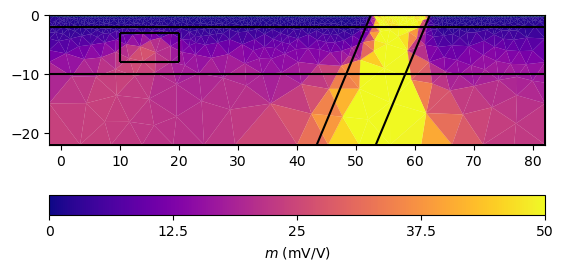

In [51]:
geo = mt.readPLC("geo.poly")
ax, cb = pg.show(mgr.paraDomain, modelIP*1000, logScale=False, label=r"$m$ (mV/V)", 
                 cMap="plasma", cMin=0, cMax=50)
pg.viewer.mpl.drawPLC(ax, geo, fitView=False, fillRegion=False)